In [268]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.integrate as integrate
from astropy.table import Table
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("font", size=20)

In [236]:
def imf(m, alpha=-2.35):
    return m**(alpha)

# number of stars with M1 < M < M2
def nstars(m1, m2):
    return (m1**(-1.35) - m2**(-1.35)) / 1.35

# total mass of stars with M1 < M < M2
def mstars(m1, m2):
    return (m1**(-0.35) - m2**(-0.35)) / 0.35

def age_mass_ms(mass):
    return 10**10 * mass**(-2.5)

def age_mass_rgb(mass):
    return 10**9 * mass**(-4.0)

# solve to find stars that are still red giants
def rgb_mass_cond(mass, time):
    return age_mass_ms(mass) + age_mass_rgb(mass) - time

# Maximum stellar mass which will be a RG at t=10**10 yrs
max_rgb_mass = opt.newton(rgb_mass_cond, 1.0, args=(10**10,))

In [237]:
# Total fraction of surviving stars

total_stars = nstars(0.1, max_rgb_mass)

frac_group1 = nstars(0.1, 0.75) / total_stars
frac_group2 = nstars(0.75, 1.0) / total_stars
frac_group3 = nstars(1.0, max_rgb_mass) / total_stars

print(frac_group1, frac_group2, frac_group3)

0.9756346683258504 0.022140358757203427 0.0022249729169461024


In [238]:
# Total mass of surviving stars

total_mass = mstars(0.1, max_rgb_mass_remaining)

frac_mass_group1 = mstars(0.1, 0.75) / total_mass
frac_mass_group2 = mstars(0.75, 1.0) / total_mass
frac_mass_group3 = mstars(1.0, max_rgb_mass_remaining) / total_mass

print(frac_mass_group1, frac_mass_group2, frac_mass_group3)

0.9052820097947869 0.08465712343804256 0.010060866767170653


In [239]:
# Total luminosity of the galaxy

def lum_mass_ms(mass):
    return mass**3.5

def lum_mass_rgb(mass):
    return 100 * lum_mass_ms(mass)

# total luminosity of stars with M1 < M < M2
def lumstars(m1, m2):
    if(m2 < 1.0):
        return (m2**2.15 - m1**2.15) / 2.15
    else:
        return (1.0**2.15 - m1**2.15) / 2.15 + 100 * (m2**2.15 - 1**2.15) / 2.15

total_lum = lumstars(0.1, max_rgb_mass)

frac_lum_group1 = lumstars(0.1, 0.75) / total_lum
frac_lum_group2 = lumstars(0.75, 1.0) / total_lum
frac_lum_group3 = lumstars(1.0, max_rgb_mass_remaining) / total_lum

print(frac_lum_group1, frac_lum_group2, frac_lum_group3)

0.05851288003719789 0.050764182738806694 0.8907229372239953


['Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag']


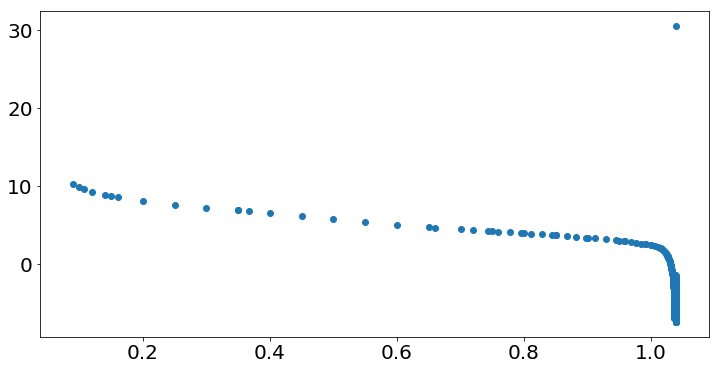

In [240]:
isochrone = Table.read('isoc_10gyr.dat', format='ascii')
print(isochrone.colnames)

plt.figure(figsize=(12,6))
plt.scatter(isochrone['Mini'], isochrone['Kmag']);

The total K band luminosity is given by integrating over all masses. As the equivalent width and the number of stars at a given mass are also functions of mass they must be included in the integral.

The measured equivalent width is an average of the equivalent widths from each of the stellar spectra. The equivalent width for each of the spectra is a function of the corresponding star's mass and so the average needs to be weighted by the probability of each stellar mass occuring and by the K-band luminosity of each mass.

Hence strength = $$\frac{\int\mathrm{EW}(M)L_K(M)N(M)\,\mathrm{d}M}{\int L_K(M)N(M)\,\mathrm{d}M}$$

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Equivalent width is: 2.1426


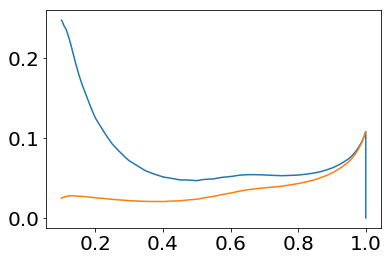

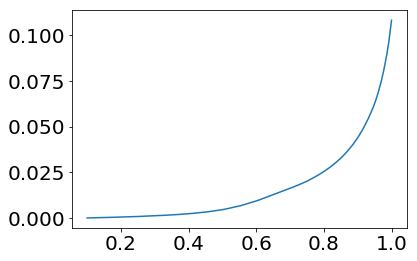

In [269]:
def eq_width(initial_mass):
    return np.where(initial_mass < 1,
                    1.0/initial_mass,
                    np.zeros_like(initial_mass))

solmassarg= np.argmin(np.abs(isochrone['Mass']-1))

lum_k = 10**(-0.4 * isochrone['Kmag']) #* (10**0.4 * solar_k_mag)
# the solar K-band magnitude doesn't matter because it is a constant
# so it comes out the front of both integrals and cancels
lum_k_interp = interp.interp1d(isochrone['Mini'], lum_k)

top = lambda m: eq_width(m) * lum_k_interp(m) * imf(m)
#np.sum(eq_width(masses) * lum_k_interp(masses) * imf(masses))
bottom = lambda m: lum_k_interp(m) * imf(m)
#bottom = np.sum(lum_k_interp(masses) * imf(masses))

width = integrate.quad(top, 0.1, 1)[0] / integrate.quad(bottom, 0.1, 1)[0]
print('Equivalent width is: {:.5g}'.format(width))

masses = np.arange(0.1, 1.0, 0.000001)
plt.figure()
plt.plot(masses, top(masses))
plt.plot(masses, bottom(masses))

plt.figure()
plt.plot(masses, lum_k_interp(masses));

In [242]:
tol = 0.3

def optimise_slope(alpha, sgn=1):
    top = lambda m: eq_width(m) * lum_k_interp(m) * imf(m, alpha)
    bottom = lambda m: lum_k_interp(m) * imf(m, alpha)
    ew = integrate.quad(top, 0.1, 1)[0] / integrate.quad(bottom, 0.1, 1)[0]
    return (2.1426 + sgn * tol - ew)
    
alpha = opt.newton(optimise_slope, -2.35)
alpha2 = opt.newton(optimise_slope, -2.35, args=(-1,))
print(alpha, alpha2)

slopes = np.linspace(-1.9, -2.7, 100)
ews = []
for alpha in slopes:
    top = lambda m: eq_width(m) * lum_k_interp(m) * imf(m, alpha)
    bottom = lambda m: lum_k_interp(m) * imf(m, alpha)
    ews.append(integrate.quad(top, 0.1, 1)[0] / integrate.quad(bottom, 0.1, 1)[0])

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


-2.629718128273394 -1.9755603367580166


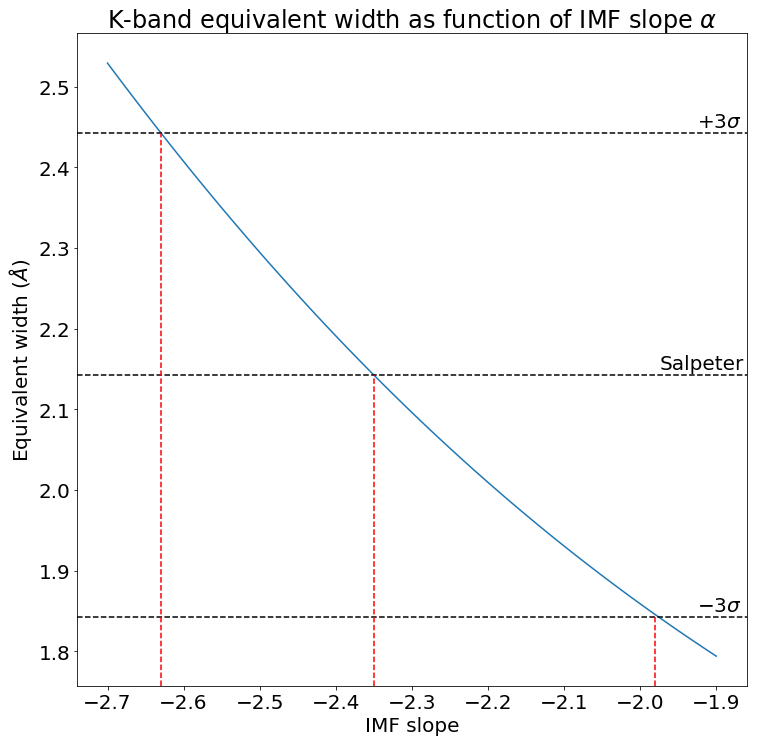

In [264]:
plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.set_xlabel('IMF slope')
ax.set_ylabel(r'Equivalent width $(\AA)$')
ax.set_title(r'K-band equivalent width as function of IMF slope $\alpha$')
plt.plot(slopes, ews)
ax.axhline(2.1426, c='k', ls='--')
ax.text(-1.925, 1.85, r'$-3\sigma$')
ax.axhline(2.1426-tol, c='k', ls='--')
ax.text(-1.975, 2.15, 'Salpeter')
ax.axhline(2.1426+tol, c='k', ls='--')
ax.text(-1.925, 2.45, r'$+3\sigma$')
rge = (ax.get_ylim()[1] - ax.get_ylim()[0])
plusheight = (2.1426 + tol - ax.get_ylim()[0]) / rge
minheight = (2.1426 - tol - ax.get_ylim()[0]) / rge
salpheight = (2.1426 - ax.get_ylim()[0]) / rge
ax.axvline(-2.63, ymax=plusheight, c='r', ls='--');
ax.axvline(-1.98, ymax=minheight, c='r', ls='--');
ax.axvline(-2.35, ymax=salpheight, c='r', ls='--');

plt.savefig('imf_slope_3sigma.pdf')